# Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install salib
from SALib.sample import saltelli
from SALib.analyze import sobol

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.7/778.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00


In [ ]:
# Used for styling of graphs
!pip install SciencePlots

import scienceplots
plt.style.use(['science', 'grid', 'no-latex'])

# Creating Model

In [ ]:
from scipy.optimize import curve_fit

# Initialises data
xData = np.array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])
yData = np.array([98, 173, 279, 422, 588, 716, 854, 907, 1139, 1364, 1637, 2074, 2767, 3397])
xData -= np.min(xData)

def logistic(xData, L, k, x0):
  return L / (1 + np.exp(-k * (xData - x0)))

L = 100000
logisticFunc = lambda xData, k, x0: logistic(xData, L, k, x0)

# Calculates the paramaters of the model
popt, pcov = curve_fit(logisticFunc, xData, yData,
                       bounds=([0, 0], [np.inf, np.inf]), maxfev=10000)

model = lambda xData: logistic(xData, L, *popt)

# Sensitivity Analysis

In [ ]:
paramNames = np.array(['L', 'k', 'x0'])

# Defines parameters and bounds for the sensitivity analysis
problem = {
    'num_vars': len(paramNames),
    'names': paramNames,
    'bounds': [[x * 0.95, x * 1.05] for x in np.insert(popt, 0, L, axis=0)]
}

In [ ]:
# Creates samples
paramValues = saltelli.sample(problem, 64)

# Evaluates samples over relevant domain for each parameter set
x = np.linspace(0, 30, 100)
y = np.array([logistic(x, *params) for params in paramValues])

# Calculates the indicies of the parameters at each x value
sobolIndices = [sobol.analyze(problem, Y) for Y in y.T]

<ipython-input-6-a240d2ed3d6a>:2: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  paramValues = saltelli.sample(problem, 64)


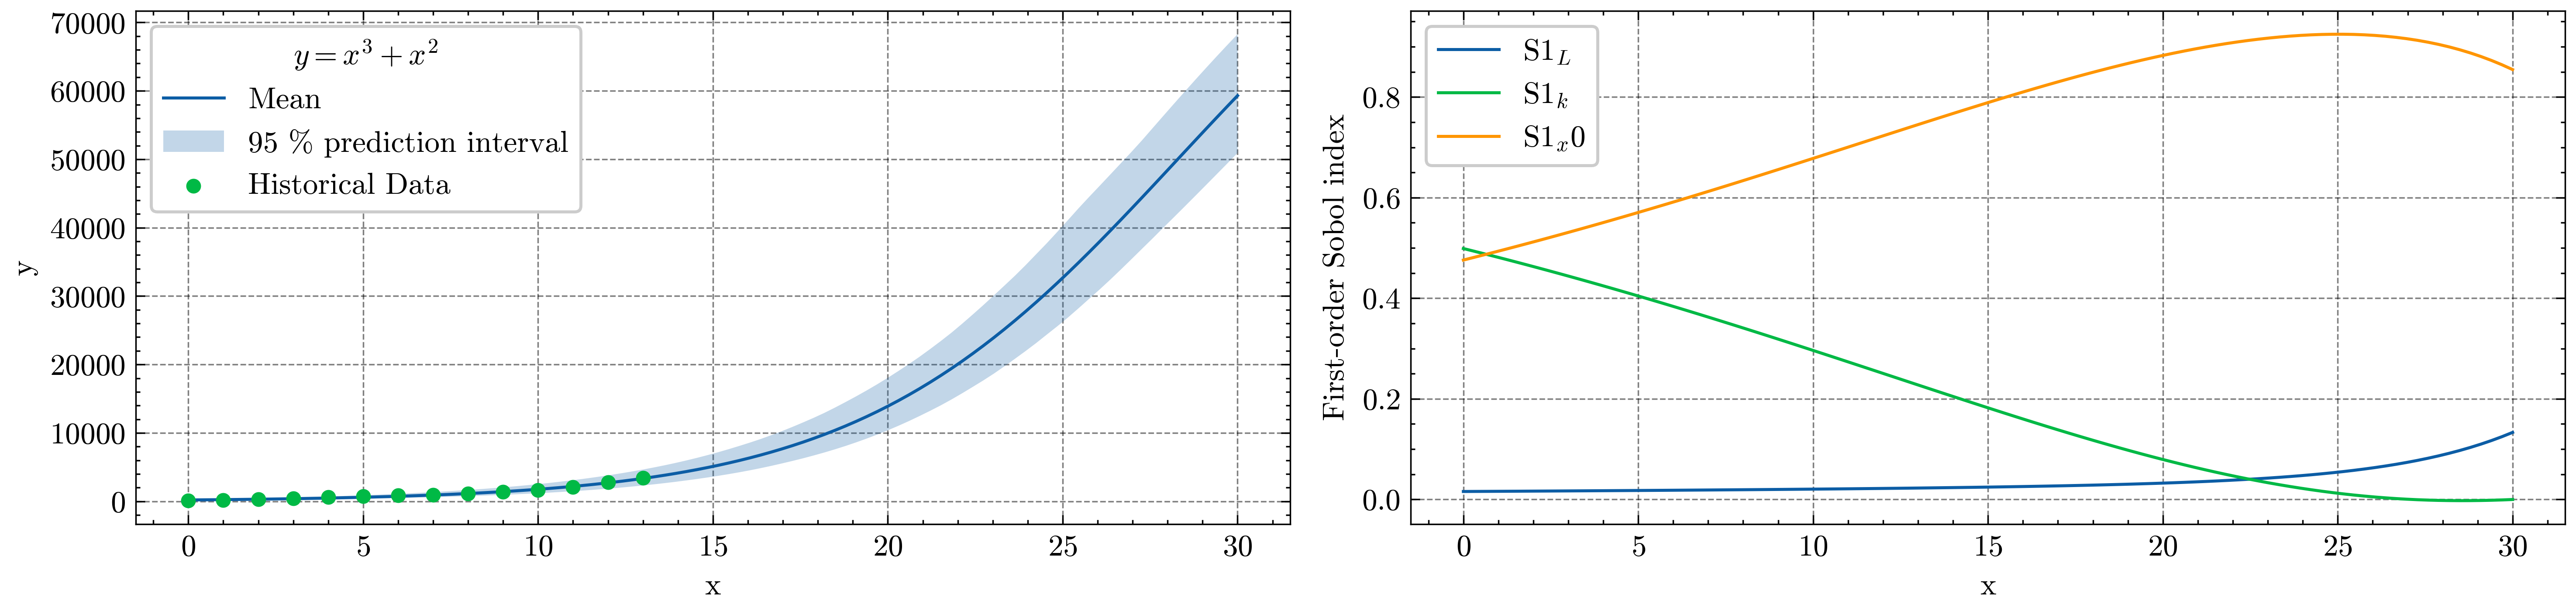

In [ ]:
# Retrieves the first order indicies
s1Sense = np.array([s['S1'] for s in sobolIndices])
PREDICTION_INTERVAL = 95
EQUATION = r"$y=x^3+x^2$"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=500)

# Plots the regression and the past data
axes[0].plot(x, model(x), label="Mean")
axes[0].scatter(xData, yData, marker="o", s=15, label="Historical Data", zorder=2)

# Plots the confidence region within the prediction interval
axes[0].fill_between(x,
                 np.percentile(y, 50 - PREDICTION_INTERVAL / 2, axis=0),
                 np.percentile(y, 50 + PREDICTION_INTERVAL / 2, axis=0),
                 alpha=0.25,
                 label=f"{PREDICTION_INTERVAL}% Confidence Interval")


axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].legend(title=EQUATION)


# Plots the first order indicies of each of the parameters against x
for i in range(len(paramNames)):
  axes[1].plot(x, s1Sense[:, i],
          label=f'S1$_{paramNames[i]}$')

axes[1].set_xlabel("x")
axes[1].set_ylabel("First-order Sobol index")

axes[1].legend()

fig.tight_layout()
plt.show()